In [1]:
import os
import re

import pandas as pd
import numpy as np
import unicodedata
import matplotlib.pyplot as plt

import collections
import wordcloud as wc

import nltk

# Resume

In [2]:
input_path = "data/cdiscount_train.csv.zip"
nb_line=100000  # part totale extraite du fichier initial ici déjà réduit
data_all = pd.read_csv(input_path, sep=",", nrows=nb_line)
data_all = data_all.fillna("") # pour les valeurs nulles
data_all.head()

,Categorie1,Categorie2,Categorie3,Description,Libelle,Marque
0,INFORMATIQUE,CONNECTIQUE - ALIMENTATION,BATTERIE,Batterie Acer Aspire One 751H-52Yr - Li-Ion 11...,Batterie Acer Aspire One 751H-52Yr,AUCUNE
1,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque rigide Bleu lagon pour ALCATEL OT / 6033...,Coque rigide Bleu lagon pour ALCATEL OT / 6033 …,MUZZANO
2,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Facades et coques CELLULAR LINE SHCKGALS 3 MIN...,Facades et coques CELLULAR LINE SHCKGALS 3 MINIP,CELLULAR LINE
3,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque meteore TPU LG Nexus 4 / E960,Coque meteore TPU LG Nexus 4 / E960,AUCUNE
4,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque souple Transparente pour LG G FLEX D959 ...,Coque souple Transparente pour LG G FLEX D959 m…,MUZZANO


In [3]:
data = data_all[["Categorie1","Description"]]
data

,Categorie1,Description
0,INFORMATIQUE,Batterie Acer Aspire One 751H-52Yr - Li-Ion 11...
1,TELEPHONIE - GPS,Coque rigide Bleu lagon pour ALCATEL OT / 6033...
2,TELEPHONIE - GPS,Facades et coques CELLULAR LINE SHCKGALS 3 MIN...
3,TELEPHONIE - GPS,Coque meteore TPU LG Nexus 4 / E960
4,TELEPHONIE - GPS,Coque souple Transparente pour LG G FLEX D959 ...
...,...,...
99995,DECO - LINGE - LUMINAIRE,Souvenirs de France - Tour Eiffel Miniature 'P...
99996,LIBRAIRIE,Fast Track to Waste-Free Manufacturing - John ...
99997,TELEPHONIE - GPS,fitBAG Bonga Girafe housse pochette pour télép...
99998,DECO - LINGE - LUMINAIRE,grand tableau minnie T 50x50 cm


In [4]:
data.describe()

,Categorie1,Description
count,100000,100000
unique,44,96591
top,TELEPHONIE - GPS,4400mAh | 10.8V | Li-ion - 4400mAh | 10.8V | L...
freq,21325,97


### Comments: 
    - The dataset is composed of 44 categories. 
    - The main one includes 21 325 products (over 100 000). 
    - Some descriptions are redundants

# Descriptive statistics and graphs

In [5]:
data['Categorie1'].value_counts()

TELEPHONIE - GPS                              21325
INFORMATIQUE                                  14597
LIBRAIRIE                                     12121
VETEMENTS - LINGERIE                           6023
BIJOUX -  LUNETTES - MONTRES                   6014
DECO - LINGE - LUMINAIRE                       5866
AUTO - MOTO (NEW)                              4714
BRICOLAGE - OUTILLAGE - QUINCAILLERIE          3141
SPORT (NEW)                                    2565
ELECTROMENAGER                                 2152
JOUET (NEW)                                    2038
BAGAGERIE                                      1912
CULTURE / JEUX                                 1819
PHOTO - OPTIQUE                                1574
CHAUSSURES - ACCESSOIRES                       1391
MEUBLE                                         1383
HYGIENE - BEAUTE - PARFUM                      1362
JARDIN - PISCINE                               1358
ART DE LA TABLE - ARTICLES CULINAIRES          1107
LOISIRS CREA

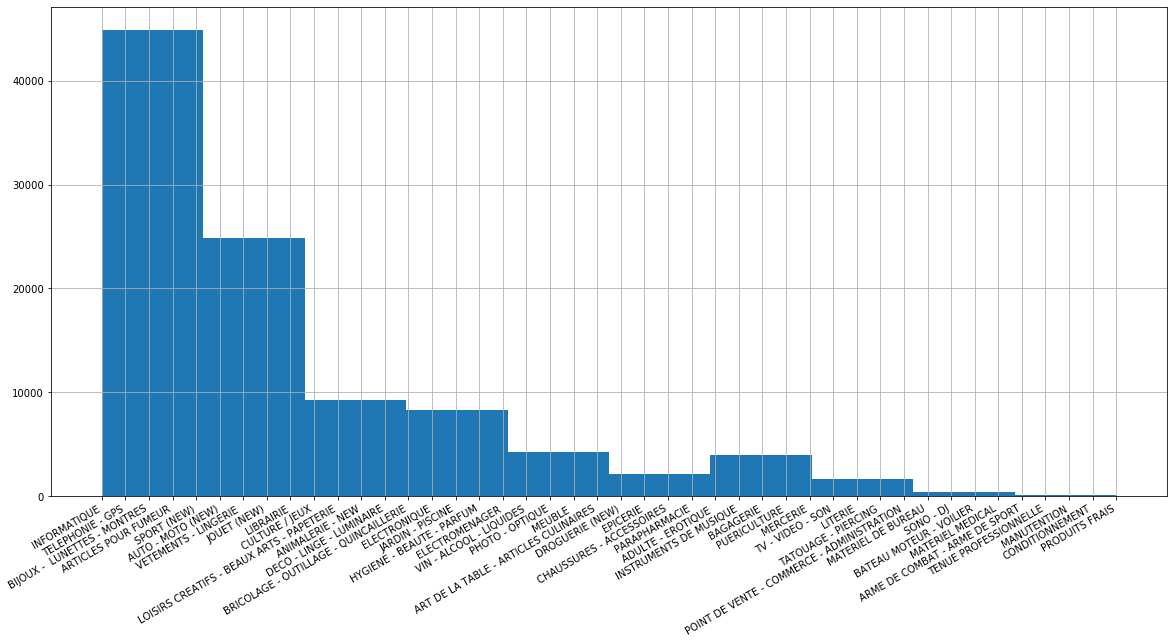

In [6]:
fig=plt.figure(figsize=(20,10))
data['Categorie1'].hist(bins=10)
fig.autofmt_xdate()

# Cleaning all the vocabulary

In [7]:
#creating a big string and add each description
voca = "" 
for k in range(nb_line):
    des = data['Description'][k]
    voca += " "
    voca += des

In [8]:
#print the number of words in the total vocabulary
print("Number of unique words in the total vocabulary :" ,len(voca.split(" ")))

Number of unique words in the total vocabulary : 2514812


In [9]:
#print the number of unique words in the total vocabulary
#thanks the split to separate each word
#the set which keeps each occurence once 
#the len to get the size of the list
print("Number of unique words in the total vocabulary :" ,len(set(voca.split(" "))))

Number of unique words in the total vocabulary : 219119


### Comments:
    - the amount of vocabulary is huge and full of "non sense" words/characters such as ">" "@" "voir" "présentation"
    - we need to "clean" the data to get the vocabulary we are really interested in

In [10]:
#removing special characters and put the vocabulary in lower
cleaned_voc = voca
cleaned_voc = cleaned_voc.lower()
cleaned_voc = cleaned_voc.replace(u'\u2026','.')
cleaned_voc = cleaned_voc.replace(u'\u00a0',' ')


print("Number of unique words in the total vocabulary, after the first step of cleaning :" ,len(set(cleaned_voc.split(" "))))

Number of unique words in the total vocabulary, after the first step of cleaning : 183998


In [11]:
#takes off some punctuation
cleaned_voc = unicodedata.normalize('NFD', cleaned_voc).encode('ascii', 'ignore').decode("utf-8")
print("Number of unique words in the total vocabulary, after the second step of cleaning :" ,len(set(cleaned_voc.split(" "))))

Number of unique words in the total vocabulary, after the second step of cleaning : 178766


In [12]:
#keeps only alphabet letters
cleaned_voc = re.sub('[^a-z_]', ' ', cleaned_voc)
print("Number of unique words in the total vocabulary, after the third step of cleaning :" ,len(set(cleaned_voc.split(" "))))

Number of unique words in the total vocabulary, after the third step of cleaning : 75679


### Comments:
    - since we have removed many characters and words, which are not from the alphabet, we are able to remove the ones which are from the french language but meaningless in that coontext such as: "le" "la" "auxquelles" "du" those articlesen & pronouns.
    - to do so, we need to charge the french stopword from the library nltk (very trendy lib used in NLP)

In [13]:
## Words to delete from the descriptions
## Using NLTK
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words('french') 

stopwords[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cecile/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle']

In [14]:
#removing what in the stopwords ??? punctuation ?
stopwords = [unicodedata.normalize('NFD', sw).encode('ascii', 'ignore').decode("utf-8") for sw in stopwords]
stopwords += ["voir"]
stopwords += ["presentation"]
stopwords[:10]

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle']

In [15]:
#creation of tokens and removing the french stop word & words of 3 letters
tokens = [w for w in cleaned_voc.split(" ") if (len(w)>2) and (w not in stopwords)]
removed_words = [w for w in cleaned_voc.split(" ") if (len(w)<2) or (w in stopwords)]

In [16]:
#removed_words and examples of some tokens
print("Removed words :")
print(set(removed_words), '\n')

print("Some tokens :")
print(tokens[:100])

Removed words :
{'', 'mes', 'serait', 'etant', 'pour', 'soient', 'sommes', 'mon', 'notre', 'f', 'et', 'h', 'qui', 'au', 'd', 'avions', 'etiez', 'une', 'avais', 'le', 'votre', 'la', 'etions', 'je', 'ces', 'seriez', 'furent', 'l', 'avons', 'x', 'm', 'r', 'ta', 'me', 'i', 'que', 'il', 'en', 'auras', 'dans', 'ai', 'de', 'moi', 'les', 'mais', 'nos', 'etes', 'ce', 'futes', 'ton', 'k', 'presentation', 'p', 'vos', 'ils', 'voir', 'es', 'v', 'aura', 'avez', 'ayant', 'suis', 'j', 'te', 'eus', 'ayez', 'aurez', 'ait', 'soit', 'par', 'se', 'toi', 'ma', 'aurons', '_', 'meme', 'seront', 'fut', 'eu', 'un', 'sa', 'ayons', 'nous', 'lui', 'du', 'n', 'seraient', 'sera', 'etait', 'qu', 'ou', 'aurait', 'avec', 'y', 'e', 'ne', 'g', 'aux', 'ete', 'ses', 'as', 'vous', 'c', 'tes', 'ont', 'b', 'o', 'u', 'on', 'fus', 'aviez', 's', 'soyez', 'a', 'etaient', 'pas', 'q', 'aient', 'z', 'eux', 'son', 'fumes', 'est', 'leur', 'sont', 'auront', 'sur', 'tu', 'elle', 'des', 'w', 'seras', 't', 'serez', 'avait', 'auriez'} 

So

In [17]:
## Stemming function to get roots of words
stemmer=nltk.stem.SnowballStemmer('french')
tokens_stem = [stemmer.stem(token) for token in tokens]
print(tokens_stem[:10])

['batter', 'acer', 'aspir', 'one', 'ion', 'mah', 'noir', 'compatibl', 'batter', 'coqu']


In [18]:
print("Number of tokens we have after the cleaning :" ,len(set(tokens_stem)))

Number of tokens we have after the cleaning : 58219


### Comments:
    - we finally get the vocabulary we need.

# WordCloud to visualize the vocabulary

In [19]:
#creation of the wordcloud 
#generate from frequencies helps
wordcloud = wc.WordCloud().generate_from_frequencies(collections.Counter(tokens_stem))

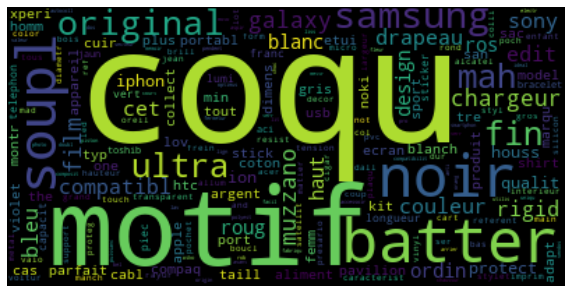

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Cleaning of the vocabulary per category (3 of them)

## Initialization of the vocabulary

In [21]:
#creation of subdata set for the 3 biggest categories
data_1=data[data["Categorie1"]=="TELEPHONIE - GPS"]
data_2=data[data["Categorie1"]=="INFORMATIQUE"]
data_3=data[data["Categorie1"]=="LIBRAIRIE"]

In [22]:
#initialization of the vocabulary of the category TEL - GPS
voca_1 = "" 
for l in data_1.values[:,1]:
    voca_1 += " "
    voca_1 += l

print("Number of words in the TEL/GPS vocabulary :" ,len(voca_1.split(" ")))
print("Number of unique words in the TEL/GPS vocabulary :" ,len(set(voca_1.split(" "))))

Number of words in the TEL/GPS vocabulary : 666273
Number of unique words in the TEL/GPS vocabulary : 24823


In [23]:
#initialization of the vocabulary of the category INFO
voca_2 = "" 
for l in data_2.values[:,1]:
    voca_2 += " "
    voca_2 += l

print("Number of words in the INFO vocabulary :" ,len(voca_2.split(" ")))
print("Number of unique words in the INFO vocabulary :" ,len(set(voca_2.split(" "))))

Number of words in the INFO vocabulary : 350279
Number of unique words in the INFO vocabulary : 34009


In [24]:
#initialization of the vocabulary of the category LIBRAIRIE
voca_3 = "" 
for l in data_3.values[:,1]:
    voca_3 += " "
    voca_3 += l
    
print("Number of words in the LIBRAIRIE vocabulary :" ,len(voca_3.split(" ")))
print("Number of unique words in the LIBRAIRIE vocabulary :" ,len(set(voca_3.split(" "))))

Number of words in the LIBRAIRIE vocabulary : 104108
Number of unique words in the LIBRAIRIE vocabulary : 22468


## Cleaning

In [25]:
cleaned_voc_1 = voca_1
cleaned_voc_1 = cleaned_voc_1.lower()
cleaned_voc_1 = cleaned_voc_1.replace(u'\u2026','.')
cleaned_voc_1 = cleaned_voc_1.replace(u'\u00a0',' ')

print("Number of unique words in the TEL/GPS vocabulary, after the first step of cleaning :" ,len(set(cleaned_voc_1.split(" "))))

Number of unique words in the TEL/GPS vocabulary, after the first step of cleaning : 20521


In [26]:
cleaned_voc_2 = voca_2
cleaned_voc_2 = cleaned_voc_2.lower()
cleaned_voc_2 = cleaned_voc_2.replace(u'\u2026','.')
cleaned_voc_2 = cleaned_voc_2.replace(u'\u00a0',' ')
print("Number of unique words in the INFO vocabulary, after the first step of cleaning :" ,len(set(cleaned_voc_2.split(" "))))

Number of unique words in the INFO vocabulary, after the first step of cleaning : 31014


In [27]:
cleaned_voc_3 = voca_3
cleaned_voc_3 = cleaned_voc_3.lower()
cleaned_voc_3 = cleaned_voc_3.replace(u'\u2026','.')
cleaned_voc_3 = cleaned_voc_3.replace(u'\u00a0',' ')
print("Number of unique words in the LIBRAIRIE vocabulary, after the first step of cleaning :" ,len(set(cleaned_voc_3.split(" "))))

Number of unique words in the LIBRAIRIE vocabulary, after the first step of cleaning : 20523


In [28]:
cleaned_voc_1 = unicodedata.normalize('NFD', cleaned_voc_1).encode('ascii', 'ignore').decode("utf-8")
print("Number of unique words in the TEL/GPS vocabulary, after the second step of cleaning :" ,len(set(cleaned_voc_1.split(" "))))

Number of unique words in the TEL/GPS vocabulary, after the second step of cleaning : 20045


In [29]:
cleaned_voc_2 = unicodedata.normalize('NFD', cleaned_voc_2).encode('ascii', 'ignore').decode("utf-8")
print("Number of unique words in the INFO vocabulary, after the second step of cleaning :" ,len(set(cleaned_voc_2.split(" "))))

Number of unique words in the INFO vocabulary, after the second step of cleaning : 30754


In [30]:
cleaned_voc_3 = unicodedata.normalize('NFD', cleaned_voc_3).encode('ascii', 'ignore').decode("utf-8")
print("Number of unique words in the TEL/GPS vocabulary, after the second step of cleaning :" ,len(set(cleaned_voc_3.split(" "))))

Number of unique words in the TEL/GPS vocabulary, after the second step of cleaning : 20233


In [31]:
cleaned_voc_1 = re.sub('[^a-z_]', ' ', cleaned_voc_1)
print("Number of unique words in the TEL/GPS vocabulary, after the third step of cleaning :" ,len(set(cleaned_voc_1.split(" "))))

Number of unique words in the TEL/GPS vocabulary, after the third step of cleaning : 10963


In [32]:
cleaned_voc_2 = re.sub('[^a-z_]', ' ', cleaned_voc_2)
print("Number of unique words in the INFO vocabulary, after the third step of cleaning :" ,len(set(cleaned_voc_2.split(" "))))

Number of unique words in the INFO vocabulary, after the third step of cleaning : 8344


In [33]:
cleaned_voc_3 = re.sub('[^a-z_]', ' ', cleaned_voc_3)
print("Number of unique words in the LIBRAIRIE vocabulary, after the third step of cleaning :" ,len(set(cleaned_voc_3.split(" "))))

Number of unique words in the LIBRAIRIE vocabulary, after the third step of cleaning : 17003


In [34]:
#creation of tokens and removing the french stop word & words of 3 letters
tokens_1 = [w for w in cleaned_voc_1.split(" ") if (len(w)>2) and (w not in stopwords)]
removed_words_1 = [w for w in cleaned_voc_1.split(" ") if (len(w)<2) or (w in stopwords)]

In [35]:
#creation of tokens and removing the french stop word & words of 3 letters
tokens_2 = [w for w in cleaned_voc_2.split(" ") if (len(w)>2) and (w not in stopwords)]
removed_words_2 = [w for w in cleaned_voc_2.split(" ") if (len(w)<2) or (w in stopwords)]

In [36]:
#creation of tokens and removing the french stop word & words of 3 letters
tokens_3 = [w for w in cleaned_voc_3.split(" ") if (len(w)>2) and (w not in stopwords)]
removed_words_3 = [w for w in cleaned_voc_3.split(" ") if (len(w)<2) or (w in stopwords)]

In [37]:
## Stemming function to get roots of words
stemmer=nltk.stem.SnowballStemmer('french')
tokens_stem_1 = [stemmer.stem(token) for token in tokens_1]
print(tokens_stem_1[:10])

['coqu', 'rigid', 'bleu', 'lagon', 'alcatel', 'motif', 'drapeau', 'liberi', 'film', 'coqu']


In [38]:
## Stemming function to get roots of words
stemmer=nltk.stem.SnowballStemmer('french')
tokens_stem_2 = [stemmer.stem(token) for token in tokens_2]
print(tokens_stem_2[:10])

['batter', 'acer', 'aspir', 'one', 'ion', 'mah', 'noir', 'compatibl', 'batter', 'batter']


In [39]:
## Stemming function to get roots of words
stemmer=nltk.stem.SnowballStemmer('french')
tokens_stem_3 = [stemmer.stem(token) for token in tokens_3]
print(tokens_stem_3[:10])

['teo', 'edit', 'emmanuel', 'proust', 'saint', 'seii', 'next', 'dimens', 'tom', 'monograph']


In [40]:
print("Number of tokens we have after the cleaning for TEL/GPS:" ,len(set(tokens_stem_1)))
print("Number of tokens we have after the cleaning for INFO:" ,len(set(tokens_stem_2)))
print("Number of tokens we have after the cleaning for LIBRAIRIE:" ,len(set(tokens_stem_3)))

Number of tokens we have after the cleaning for TEL/GPS: 8395
Number of tokens we have after the cleaning for INFO: 6424
Number of tokens we have after the cleaning for LIBRAIRIE: 14759


# WordCloud to visualize the tokens

In [41]:
#creation of the wordcloud 
#generate from frequencies helps
wordcloud_1 = wc.WordCloud().generate_from_frequencies(collections.Counter(tokens_stem_1))

In [42]:
#creation of the wordcloud 
#generate from frequencies helps
wordcloud_2 = wc.WordCloud().generate_from_frequencies(collections.Counter(tokens_stem_2))

In [43]:
#creation of the wordcloud 
#generate from frequencies helps
wordcloud_3 = wc.WordCloud().generate_from_frequencies(collections.Counter(tokens_stem_3))

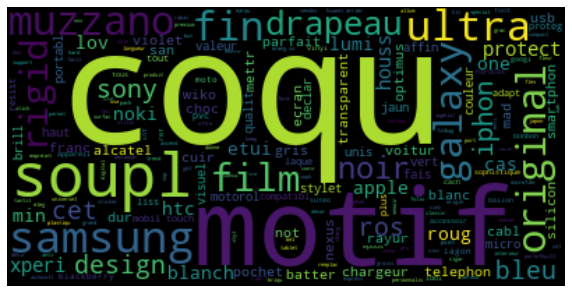

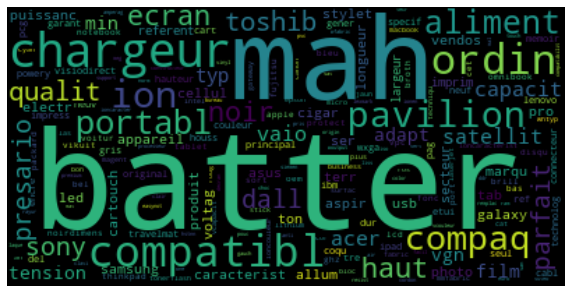

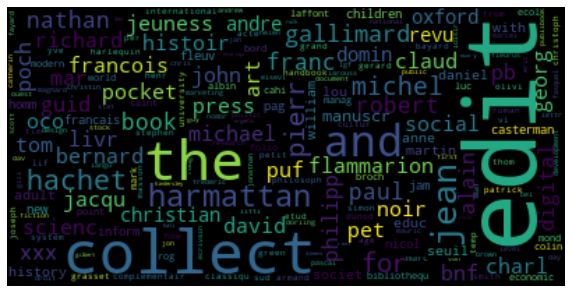

In [44]:
#wordcloud of tel/gps 's tokens
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

#wordcloud of info's tokens
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")
plt.show()

#wordcloud of librairie's tokens
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
plt.imshow(wordcloud_3, interpolation='bilinear')
plt.axis("off")
plt.show()

### Comments:
    - present and voir are still taking part of the wordclouds, we need to include this words stopwords list
    - the tokens from the total voc are from subset of categories' tokens as expected 

### Visualization of the results

In [46]:
print("Steps of the cleaning  |    Before   |  Step1  |  Step2  |  Step3  | Tokens | Final Tokens |")
print(" TELEPHONIE-GPS        |    666 273  |  24 823 |  20 521 |  20 045 | 10 963 |     8 396    |")
print(" INFORMATIQUE          |    350 279  |  34 009 |  31 014 |  30 754 |  8 344 |     6 425    |")
print(" LIBRAIRIE             |    104 108  |  22 468 |  20 523 |  20 223 | 17 003 |    14 166    |")
print(" ALL                   |  2 514 812  | 219 119 | 183 998 | 178 766 | 75 679 |    58 219    |")

Steps of the cleaning  |    Before   |  Step1  |  Step2  |  Step3  | Tokens | Final Tokens |
 TELEPHONIE-GPS        |    666 273  |  24 823 |  20 521 |  20 045 | 10 963 |     8 396    |
 INFORMATIQUE          |    350 279  |  34 009 |  31 014 |  30 754 |  8 344 |     6 425    |
 LIBRAIRIE             |    104 108  |  22 468 |  20 523 |  20 223 | 17 003 |    14 166    |
 ALL                   |  2 514 812  | 219 119 | 183 998 | 178 766 | 75 679 |    58 219    |


### Comments:
    - we notice that the category LIBRAIRIE has much more tokens than TEL GPS whereas the vocabulary of TEL GPS is six time bigger.
    - the values of the final tokens are incorrect since "voir" and "presentation" have been added at the stopwords
    - the LIBRAIRIE vocabulary is more dense than the other vocabulary because there are many differents authors so few words are recurrents.